# Capstone - Prague rental yields
Buying a real estate object with the intention of renting it out has been a popular portfolio diversification choice for decades. Calculating the return on investment (ROI) usually consists of two components, immediate short-term returns (i.e. rental yields) and long term returns captured when reselling the object (i.e. capital gain).

The drivers of return differ due to many different factors, one of which is geography1. This can be seen comparing the real estate price evolution in Prague compared to London with Prague seeing a much deeper negative growth in the start of the 2010s.23 Also worth noting, is that in Czech Republic, the real estate price growth has gone from significantly negative a couple of years ago to double digit growth in Q3 2016. These fluctuations makes investments that expect capital gain returns very unpredictable. 

## Problem statement
Given the capital gain riskiness and uniqueness of the housing market in Prague, what are the key drivers, excl. capital gain, for positive return on buy-to-let investments in the real estate market of Prague, Czech Republic?

In other words, comparing object’s rental yield vs. acquisition price, are there certain factors that improve the ROI (i.e. higher rental yield to acquisition price ratio)?

## Baseline comparator - Linear Regression
We are importing our modules, our dataset and then running a simple linear regression with monthly rental price against square meters of apartment.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
py.init_notebook_mode()
%matplotlib inline


data = pd.read_csv('srealitky_rent(01-10-2017).csv')
data.describe()
rental_prices = data['price']
rental_sqm = data['usable_area']

X = sm.add_constant(rental_sqm)
y = rental_prices

model = sm.OLS(y, X)
results = model.fit()
predict_baseline = results.predict(X)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     3574.
Date:                Wed, 18 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:45:12   Log-Likelihood:                -20630.
No. Observations:                1891   AIC:                         4.126e+04
Df Residuals:                    1889   BIC:                         4.127e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1355.1396    588.613      2.302      

We then also calculate the root-mean-squared-error to set a base to compare our future model with. I am also including the R-squared score as this is "easier" to read for business purposes:

In [30]:
from sklearn.metrics import r2_score

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def performance_metric(predictions, targets):
    score = r2_score(targets, predictions)
    return score

baseline_RMSE = rmse(predict_baseline, y)
baseline_R2 = performance_metric(predict_baseline, y)
print("The baseline RMSE is: {0:.2f} and the R2 is {1:.2f}".format(baseline_RMSE, baseline_R2))

The baseline RMSE is: 13234.47 and the R2 is 0.65


I then plot the OLS prediction that was made vs. the data:

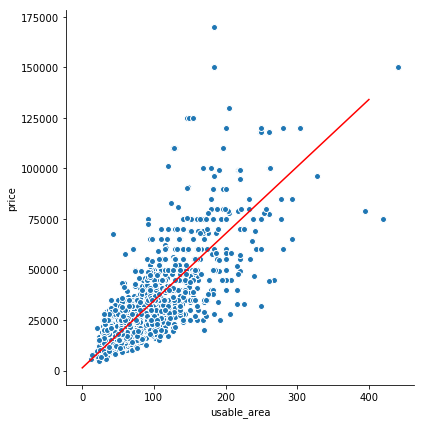

In [31]:
base_beta = results.params
X_plot = np.linspace(0,400,400)
Y_plot = base_beta [0] + base_beta[1]*X_plot

g = sns.FacetGrid(data, size = 6)
g = g.map(plt.scatter, "usable_area", "price", edgecolor="w")
plt.plot(X_plot, Y_plot, color='r')
plt.show()

At this point we have a good baseline, now it is time to explore the dataset.

## Dataset exploration + Cleaning
We start off exploring the dataset to understand what we are working with as well as cleaning up the dataset for later analysis.

Starting of looking at the description of all the data we can see that only a set of the total 49 features are numerical, and even out of these numerical ones not all of the features are present for all observations (i.e. in total we have 1891 observations, but only 1000 of those observations specify the metro_distance).

In [32]:
data.describe()

hash_id         page     latitude    longitude    company_id  \
count  1.891000e+03  1891.000000  1891.000000  1891.000000   1891.000000   
mean   2.134836e+09    48.994183    50.077970    14.431288   3590.697515   
std    1.249178e+09    27.742971     0.023744     0.047573   3153.671406   
min    3.608924e+06     1.000000    49.961201    14.279522     15.000000   
25%    1.024136e+09    25.000000    50.070314    14.407217    728.000000   
50%    2.143429e+09    49.000000    50.077727    14.429891   2492.000000   
75%    3.208256e+09    73.000000    50.090087    14.451131   6248.000000   
max    4.293989e+09    97.000000    50.157763    14.681192  10474.000000   

               price  panorama_picture    ownership  building_type_search  \
count    1891.000000            1891.0  1891.000000           1891.000000   
mean    31467.609201               1.0     1.051296              2.048123   
std     22511.415581               0.0     0.270238              0.386697   
min      4900.000000               1.0     1.000000              1.000000   
25%     16500.000000               1.0     1.000000              2.000000   
50%     25000.000000               1.0     1.000000              2.000000   
75%     38681.500000               1.0     1.000000              2.000000   
max    170000.000000               1.0     3.000000              3.000000   

       metro_distance  tram_distance  bus_distance  train_distance  \
count     1000.000000    1015.000000   1033.000000     1030.000000   
mean       763.241000     469.731034    243.872217     1146.283495   
std        672.040747     622.021071    168.490963      515.477430   
min         13.000000      18.000000      4.000000      110.000000   
25%        300.750000     124.000000    115.000000      802.750000   
50%        563.000000     221.000000    203.000000     1089.000000   
75%        957.000000     462.500000    341.000000     1485.000000   
max       3946.000000    3987.000000    853.000000     4035.000000   

       school_distance  usable_area     floorage  garden_area  \
count      1005.000000  1891.000000  1228.000000    27.000000   
mean        271.427861    90.735061    89.607492    84.074074   
std         189.181746    54.863507    52.747038    79.997561   
min          25.000000    12.000000   -71.000000     1.000000   
25%         146.000000    52.000000    52.000000    19.000000   
50%         232.000000    77.000000    77.000000    68.000000   
75%         336.000000   110.000000   110.000000   134.000000   
max        2111.000000   441.000000   441.000000   316.000000   

       reconstruction_year  
count           133.000000  
mean           2014.233083  
std               4.113701  
min            1995.000000  
25%            2014.000000  
50%            2016.000000  
75%            2017.000000  
max            2017.000000

Observing the missing datapoints for observations within features that cannot readily be assumed to be 0, I take these observations out as I don't want missing values to skew my later analysis. 

In [33]:
#dropping observations that are NaN
data.dropna(axis=0, how='any', subset=['metro_distance', 'tram_distance', 'bus_distance', 'train_distance', 'school_distance'], inplace=True)

These operations leaves us with 968 observations in the dataset. 

Now I noticed that the number of rooms of each object is locked within a string, I want to extract the number of rooms of each apartment as I think that will be useful when predicting pricing. Hence I extract the number of rooms from the "summary" feature:

In [34]:
import re

#Extract the number of rooms of each apartment
rooms = []

for i in data['summary']:
    room = i.split()[2][:1]
    try:
        val = int(room)
    except ValueError:
        room = 1
    rooms.append(int(room))

data = data.assign(num_rooms=rooms)

#Extract what floor the apartment is on
floors = []
find = re.compile(r"^[^.]*")

for l in data['floor']:
    floor = re.search(find, l).group(0)
    try:
        val = int(floor)
    except ValueError:
        floor = 0
#I accept cellar (i.e. -1 floor), but further down than that I think it is an error in the listing.
    if int(floor) < -1:
        floor = abs(int(floor))
    floors.append(int(floor))
data = data.assign(num_floor=floors)

data.describe()

hash_id        page    latitude   longitude    company_id  \
count  9.680000e+02  968.000000  968.000000  968.000000    968.000000   
mean   2.122883e+09   50.917355   50.079382   14.429108   3709.794421   
std    1.255138e+09   27.705300    0.022991    0.045874   2996.425781   
min    3.613020e+06    1.000000   50.008619   14.282118     15.000000   
25%    1.018726e+09   27.000000   50.069606   14.403305   1176.250000   
50%    2.115898e+09   52.000000   50.077725   14.431407   2492.000000   
75%    3.202978e+09   75.000000   50.090829   14.451403   6154.000000   
max    4.291105e+09   97.000000   50.139784   14.578243  10474.000000   

               price  panorama_picture   ownership  building_type_search  \
count     968.000000             968.0  968.000000            968.000000   
mean    30410.051653               1.0    1.056818              2.040289   
std     22088.544879               0.0    0.294512              0.400915   
min      5000.000000               1.0    1.000000              1.000000   
25%     16000.000000               1.0    1.000000              2.000000   
50%     23000.000000               1.0    1.000000              2.000000   
75%     36000.000000               1.0    1.000000              2.000000   
max    150000.000000               1.0    3.000000              3.000000   

       metro_distance  tram_distance  bus_distance  train_distance  \
count      968.000000     968.000000    968.000000      968.000000   
mean       763.286157     455.333678    246.016529     1155.947314   
std        661.998595     593.246627    169.756099      519.566389   
min         13.000000      18.000000      4.000000      110.000000   
25%        306.750000     123.000000    116.000000      808.000000   
50%        569.000000     217.000000    204.000000     1095.000000   
75%        961.250000     461.250000    347.000000     1496.000000   
max       3946.000000    3506.000000    853.000000     4035.000000   

       school_distance  usable_area    floorage  garden_area  \
count       968.000000   968.000000  510.000000    15.000000   
mean        259.119835    87.084711   82.545098    91.133333   
std         160.058198    50.715063   45.745440    95.996180   
min          25.000000    12.000000   12.000000     1.000000   
25%         142.750000    50.750000   50.000000     8.000000   
50%         230.500000    72.000000   70.000000    68.000000   
75%         330.000000   107.250000  103.000000   139.000000   
max        1102.000000   441.000000  250.000000   316.000000   

       reconstruction_year   num_rooms   num_floor  
count           100.000000  968.000000  968.000000  
mean           2014.270000    2.463843    3.696281  
std               4.199218    1.072711    2.304778  
min            1995.000000    1.000000   -1.000000  
25%            2014.000000    2.000000    2.000000  
50%            2016.000000    2.000000    3.000000  
75%            2017.000000    3.000000    5.000000  
max            2017.000000    6.000000   21.000000

Looking at this I would want to start exploring the data to understand how it is distributed and what we are working with:

In [35]:
price_sqm = data['price'] / data['usable_area']

trace1 = go.Histogram(x=data['price'])
trace2 = go.Histogram(x=data['usable_area'], xaxis='x2', yaxis='y2')
trace3 = go.Histogram(x=price_sqm, xaxis='x3', yaxis='y3')
graph_data = [trace1, trace2, trace3]
layout = go.Layout(title='Histogram of Prague Rental Prices and Sqm', 
                   xaxis=dict(title='Price', domain=[0,0.45]), yaxis=dict(title='Freq', domain=[0.55,1]), 
                   xaxis2=dict(title='sqm', domain=[0.55,1], anchor='y2'), yaxis2=dict(title='Freq', domain=[0.55,1], anchor='x2'),
                   xaxis3=dict(title='Price per Sqm', anchor='y3'), yaxis3=dict(title='Freq', domain=[0,0.40], anchor='x3')
                  )
fig = go.Figure(data=graph_data, layout=layout)
py.iplot(fig)

Looking at a histogram of our Prague rental prices it looks like a gamma distribution with majority of rental prices falling around 20,000 CZS and then with a long tail. The squaremeters of rental apartments in Prague is also looking like a gamma or perhaps very skewed normal distribution with the majority of flats around 55 sqm in size.

We can also see a rather large spread in price per sqm, which follows my hypothesis that there are many factors driving the price per sqm (i.e. how new an apartment is, location etc.). 

Quickly plotting Price per sqm by the size of the apartment:

In [36]:
z = np.polyfit(data['usable_area'], price_sqm, 1)
f = np.poly1d(z)

x_new = np.linspace(min(data['usable_area']), max(data['usable_area']), 50)
y_new = f(x_new)

trace4 = go.Scatter(x=data['usable_area'], y=price_sqm, mode='markers', name='Apartments')
trace5 = go.Scatter(x=x_new, y=y_new, mode='lines', name='Fit', marker=go.Marker(color='rgb(255,0,0)'))
layout = go.Layout(title="Price per sqm by size of apartment", 
                   xaxis=dict(title="Size of home (sqm)"), yaxis=dict(title="Price per sqm")
                  )
graph_data = [trace4, trace5]
fig = go.Figure(data=graph_data, layout=layout)
py.iplot(fig)

We can see a small downward trend in Price per sqm as the size of the home grows larger.

Now I also want to add to my dataseries the distance of the object from the Prague city center:

In [37]:
from math import sin, cos, sqrt, atan2, radians



def distance_to_center(lat, lon):
    # approximate radius of earth in km
    R = 6373.0
    
    #Taking the latitude of object and Prague City Center
    lat1 = radians(lat)
    lon1 = radians(lon)
    lat2 = radians(50.087536)
    lon2 = radians(14.421201)

    #Calculate the distance using geometrics and return the distance in meters
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = (R * c)*1000
    
    return int(distance)

center_distance = []

for index, series in data.iterrows():
    center_distance.append(distance_to_center(series['latitude'], series['longitude']))
    
data = data.assign(center_distance=center_distance)

data.describe()

hash_id        page    latitude   longitude    company_id  \
count  9.680000e+02  968.000000  968.000000  968.000000    968.000000   
mean   2.122883e+09   50.917355   50.079382   14.429108   3709.794421   
std    1.255138e+09   27.705300    0.022991    0.045874   2996.425781   
min    3.613020e+06    1.000000   50.008619   14.282118     15.000000   
25%    1.018726e+09   27.000000   50.069606   14.403305   1176.250000   
50%    2.115898e+09   52.000000   50.077725   14.431407   2492.000000   
75%    3.202978e+09   75.000000   50.090829   14.451403   6154.000000   
max    4.291105e+09   97.000000   50.139784   14.578243  10474.000000   

               price  panorama_picture   ownership  building_type_search  \
count     968.000000             968.0  968.000000            968.000000   
mean    30410.051653               1.0    1.056818              2.040289   
std     22088.544879               0.0    0.294512              0.400915   
min      5000.000000               1.0    1.000000              1.000000   
25%     16000.000000               1.0    1.000000              2.000000   
50%     23000.000000               1.0    1.000000              2.000000   
75%     36000.000000               1.0    1.000000              2.000000   
max    150000.000000               1.0    3.000000              3.000000   

       metro_distance       ...         bus_distance  train_distance  \
count      968.000000       ...           968.000000      968.000000   
mean       763.286157       ...           246.016529     1155.947314   
std        661.998595       ...           169.756099      519.566389   
min         13.000000       ...             4.000000      110.000000   
25%        306.750000       ...           116.000000      808.000000   
50%        569.000000       ...           204.000000     1095.000000   
75%        961.250000       ...           347.000000     1496.000000   
max       3946.000000       ...           853.000000     4035.000000   

       school_distance  usable_area    floorage  garden_area  \
count       968.000000   968.000000  510.000000    15.000000   
mean        259.119835    87.084711   82.545098    91.133333   
std         160.058198    50.715063   45.745440    95.996180   
min          25.000000    12.000000   12.000000     1.000000   
25%         142.750000    50.750000   50.000000     8.000000   
50%         230.500000    72.000000   70.000000    68.000000   
75%         330.000000   107.250000  103.000000   139.000000   
max        1102.000000   441.000000  250.000000   316.000000   

       reconstruction_year   num_rooms   num_floor  center_distance  
count           100.000000  968.000000  968.000000       968.000000  
mean           2014.270000    2.463843    3.696281      3550.603306  
std               4.199218    1.072711    2.304778      2404.036490  
min            1995.000000    1.000000   -1.000000        65.000000  
25%            2014.000000    2.000000    2.000000      1867.750000  
50%            2016.000000    2.000000    3.000000      2948.500000  
75%            2017.000000    3.000000    5.000000      4884.250000  
max            2017.000000    6.000000   21.000000     11328.000000  

[8 rows x 21 columns]

Now plotting the distance of object to different things:

In [38]:
trace1 = go.Histogram(x=data['metro_distance'], xaxis=dict(title='meters'))
trace2 = go.Histogram(x=data['tram_distance'])
trace3 = go.Histogram(x=data['bus_distance'])
trace4 = go.Histogram(x=data['train_distance'])
trace5 = go.Histogram(x=data['school_distance'])
trace6 = go.Histogram(x=data['center_distance'])

fig = tools.make_subplots(rows=3, cols=2, subplot_titles=('Metro', 'Tram', 'Bus', 'Train', 'School', 'Center'))

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,2)
fig.append_trace(trace5,3,1)
fig.append_trace(trace6,3,2)

fig['layout']['xaxis1'].update(title='meters')
fig['layout']['xaxis2'].update(title='meters')
fig['layout']['xaxis3'].update(title='meters')
fig['layout']['xaxis4'].update(title='meters')
fig['layout']['xaxis5'].update(title='meters')
fig['layout']['xaxis6'].update(title='meters')

fig['layout'].update(height=900, width=900, title='Histogram distance to amenities')

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



We can see that Metro and Tram has a gamma distribution, with many objects under 500m away from closest metro and tram station. However there are several objects which are very far, most likely those outside of the city center. However, looking at distance to bus we observe an indication that the bus coverage of Prague is higher as the highest distance to a bus stop is ~800m. Overall school are also in general close, with majority of apartments less than 500m away from the closest school.

We can also see that the median of distance to Prague city center is around 2.8km, however some are very far away from center.

Now mapping the apartments on the map of Prague, splitting our data up into quartiles depending on the rental price:

In [39]:
#Extracting only the columns we want to sort the list and then split into quartiles
sorted_data_sample = data[['latitude','longitude','price']].copy()

sorted_data_sample.sort_values(['price'], inplace=True)

quartile = int(len(sorted_data_sample)/4)

fourth_q = sorted_data_sample[:quartile]
third_q = sorted_data_sample[quartile:quartile*2]
second_q = sorted_data_sample[quartile*2:quartile*3]
first_q = sorted_data_sample[quartile*3:quartile*4]

In [40]:
#Taking the quartiles and mapping them over the map of Prague
mapbox_access_token = 'pk.eyJ1Ijoic3ZhcnRvIiwiYSI6ImNqOGlxZXpmcTEya2IzM3F5ZW51Zmx1ZTcifQ.qGn7jjaLJgP1a_wjf62rgQ'

mapbox_data = [
    go.Scattermapbox(
        lat=fourth_q['latitude'],
        lon=fourth_q['longitude'],
        mode='markers',
        name='4th Quartile',
        marker=go.Marker(
            size=5,
            color='rgb(0,255,0)'
        ),
    ),
    go.Scattermapbox(
        lat=third_q['latitude'],
        lon=third_q['longitude'],
        mode='markers',
        name='3rd Quartile',
        marker=go.Marker(
            size=5,
            color='rgb(255,255,0)'
        ),
    ),
    go.Scattermapbox(
        lat=second_q['latitude'],
        lon=second_q['longitude'],
        mode='markers',
        name='2st Quartile',
        marker=go.Marker(
            size=5,
            color='rgb(255,155,0)'
        ),
    ),    
    go.Scattermapbox(
        lat=first_q['latitude'],
        lon=first_q['longitude'],
        mode='markers',
        name='1st Quartile',
        marker=go.Marker(
            size=5,
            color='rgb(255,0,0)'
        ),
    )  
]

layout = go.Layout(
    title='Object heatmap over Prague by rent price quartile',
    autosize=False,
    width = 900,
    height = 900,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=50.0755,
            lon=14.4378
        ),
        pitch=0,
        zoom=12,
        style='light'
    ),
)

fig = dict(data=mapbox_data, layout=layout)
py.iplot(fig)

Overall we can see that our sample is taken from all over the city of Prague. Furthermore, visual analysis indicate that the center of Prague has the higher priced rentals and the further out of center you come the higher proportion of lower quartile rental object are there. Visually we can also infer that density of available rental objects in our sample are higher in the center of Prague and then lower density as we move away from the center.

There are certain areas, such as Dejvice, that are out of center but still maintain a high rents.

Time for a clean-up of the dataset to focus on the items we will be analyzing, I will drop these columns and I explain below why:

1) Locality - These are unstructured text and my focus will not be to include that in this analysis. Could be version 2.0 of the valuation model at a later date.

2) Page - Since the page the listing is on in the real estate aggregator is out of anyone's control (except the owner of the site) I am dropping this.

3) Rental_company - I don't see this having any predictive power (except perhaps that some rental agencies price their objects higher, but I want to find the underlying value of the asset) and thus exclude this.
company - same as rental_company.

4) Description - same as locality.

5) Additional_info - same as locality.

6) Entry_date - there are not enough data points here to include.

7) Panorama - every listing has one, so will not include this.

8) Ownership - I will include this as onehotencoding, so can drop this column.

9) Summary - I have already extracted the number of rooms here (which I was interested in).

10) building_type_search - I will include this as onehotencoding, so can drop this column.

11) Metro_name - for now, I will drop this but might bring it back later in the analysis.

12) Tram_name - for now, I will drop this but might bring it back later in the analysis.

13) Bus_name - for now, I will drop this but might bring it back later in the analysis.

14) Train_name - for now, I will drop this but might bring it back later in the analysis.

15) School_name - for now, I will drop this but might bring it back later in the analysis.

16) ID - I have the hash_id so don't need this

17) Updated - I don't see this as useful as it only shows when the listing was updated online.

18) Location - I don't have enough data points here to include it.

19) Floorage - I am using usable_area which has a more complete data set.

20) water-supply - same here, not enough data

21) heating - same here, not enough data

22) waste - not enough data
23) Energy_rating - I will drop this as I don't want to reduce my dataset further to be able to include this as a feature for 
now, might reconsider after looking further into the data and applying models.

24) Furnished - not enough data.

25) I am using usable_area instead.

26) Not enough data points.

In [41]:
dropped_columns = ['locality', 'page', 'rental_company', 'company_id', 'description', 'additional_info', 'entry_date',
                  'panorama_picture', 'ownership', 'summary', 'building_type_search', 'metro_name', 'tram_name',
                  'bus_name', 'train_name', 'school_name', 'ID', 'updated', 'location', 'floor',
                  'water_supply', 'heating', 'waste', 'energy_rating', 'furnished', 'floorage', 'reconstruction_year', 'date']
data.drop(dropped_columns, axis=1, inplace=True)

## Preparing data set for the model
Time to convert some of our categorical features with onehotencoding to be able to use them in our future predictive models. After this I will split the dataset up into training and testing portions.

We start with transforming some of our features into indicator functions:

In [42]:
from sklearn.feature_extraction import DictVectorizer
import math

data = data.reset_index(drop=True)



#transform into indicator, assuming the flats that don't mention having it don't have it
def indicator_transform_df(series, column):
    series.fillna(0, inplace=True)
    for index, value in enumerate(series):
        if data.loc[index,column] != 0:
            data.loc[index,column] = 1

indicator_transform_df(data['parking'],'parking')
indicator_transform_df(data['terass'],'terass')
indicator_transform_df(data['loggia'],'loggia')
indicator_transform_df(data['cellar'],'cellar')
indicator_transform_df(data['elevator'],'elevator')
indicator_transform_df(data['garage'],'garage')
indicator_transform_df(data['balcony_size'],'balcony_size')
indicator_transform_df(data['garden_area'],'garden_area')

#rename the columns to indicator function
data[['parking', 'terass', 'loggia', 'cellar', 'elevator', 'garage', 'balcony_size', 'garden_area']] = data[['parking', 'terass', 'loggia', 'cellar', 'elevator', 'garage', 'balcony_size', 'garden_area']].astype(int)
data.rename(index=str, inplace=True, columns={"parking": "ind_parking", "terass": "ind_terass", "loggia": "ind_loggia", "cellar":"ind_cellar", "elevator":"ind_elevator", "garage":"ind_garage", "balcony_size":"ind_balcony", "garden_area":"ind_garden"})

We then continue to actually onehotencode some of the features using the panda.get_dummies function. This is to be able to pass some of the categorical features into a machine learning algorithm such as what type of ownership the apartment has (personal, state owned or cooperative) etc.

In [43]:
data = pd.get_dummies(data, columns=['num_rooms', 'num_floor', 'building_type', 'property_status','ownership_czech'])

After this it is time to split the dataset up into training and testing sets. I will train on 80% of the dataset as this provide the majority of the set for training but still plenty of observations (~200) for later testing the model.

In [44]:
from sklearn.model_selection import train_test_split

features = data.drop(['hash_id', 'price'], axis=1)
prices = data['price']

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((774, 57), (194, 57), (774,), (194,))

## Developing a model
Now it is time to start trying out different models with our data and compare it against the baseline OLS model.

This is a bit of trial and error, however I want to explore the following models:

1) Decision Tree Regression

2) Random forest model 

3) Deep Learning model

### Decision Tree Regression
Starting of with the Decision Tree Regression model. The key question that needs to be answered to optimize the DecisionTreeModel is how deep should the tree be, so I evaluate the performance of several different depths and also utilizing the sklearn validate_curve to see as the training set grows how is the R2 developing.

In [45]:
from sklearn.model_selection import ShuffleSplit, learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor

def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([3,4,5,8]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

C:\Users\phili\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\figure.py:403: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



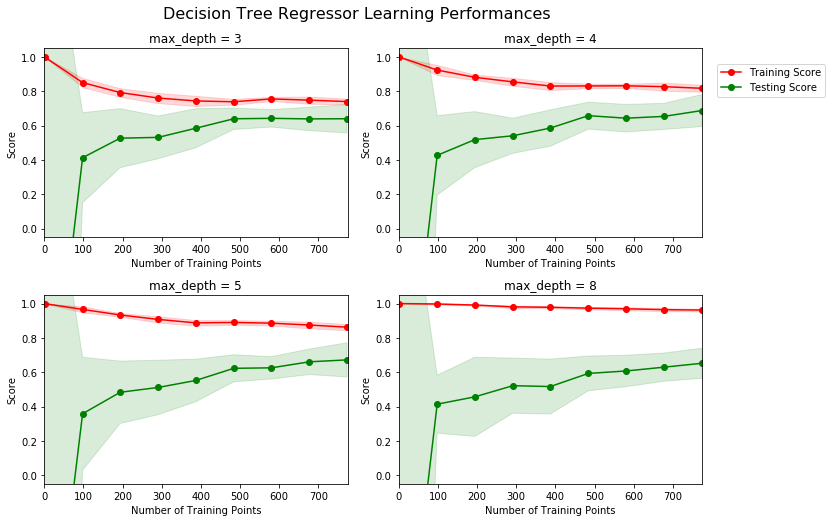

In [46]:
ModelLearning(features, prices)

As we can see here it looks like the depth 3 or 4 is the best, potentially 5 as well if we had more training points. Lets plot this across depths instead:

In [47]:
def ModelComplexity_DTR(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

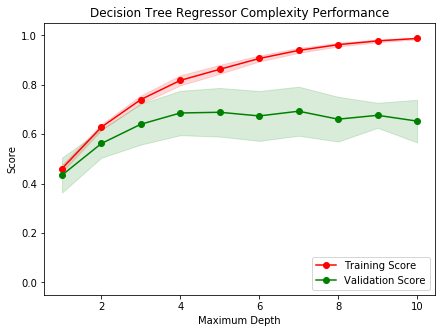

In [48]:
ModelComplexity_DTR(features, prices)

From here I see that in this case it is depth 4 that produces the best result, with the highest R2 score before it starts to diverge a lot from the training score and also fall a bit in the validation score.

In [49]:
#Setting the depth of each DecisionTreeRegressor
DTR_depth = 4
#Fit DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=DTR_depth)
regr.fit(X_train, y_train)

#Predict with testing set
y_pred = regr.predict(X_test)

#Calculate RMSE and R2
DTR_RMSE = rmse(y_pred, y_test)
DTR_R2 = performance_metric(y_pred, y_test)

print("The RMSE of the DecisionTreeRegressor is {0:.2f} for the max depth {1}".format(DTR_RMSE, DTR_depth))
print("The R2 of the DecisionTreeRegressor is {0:.2f} for the max depth {1}".format(DTR_R2, DTR_depth))
print("This is compared to Baseline OLS model RMSE of {0:.02f} and an R2 of {1:.02f}".format(baseline_RMSE, baseline_R2))

The RMSE of the DecisionTreeRegressor is 11336.05 for the max depth 4
The R2 of the DecisionTreeRegressor is 0.65 for the max depth 4
This is compared to Baseline OLS model RMSE of 13234.47 and an R2 of 0.65


Using depth 4 in the DecisionTreeRegressor and comparing the RMSE and R2 vs. the baseline OLS we can see an improvement. Specifically a rather large improvement in RMSE of around 14%. The R2 is still the same but the DecisionTreeRegressor is clearly an improvement over the baseline OLS.

### Random Forest regression

Now lets try the second model, Random Forest Regression. This is an meta estimator that fit several decision tree models on sub-samples of the data and then uses averaging to improve predictive accuracy and control for over-fitting. Similar to an ensemble method.

In [50]:
from sklearn.ensemble import RandomForestRegressor

def ModelComplexity_RFR(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(RandomForestRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

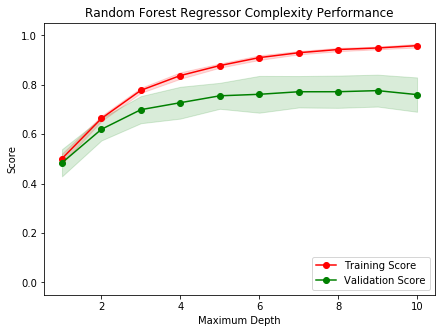

In [51]:
ModelComplexity_RFR(features, prices)

In [52]:
from sklearn.ensemble import RandomForestRegressor

RFR_depth = 7

#Fit DecisionTreeRegressor
RFR_regr = RandomForestRegressor(max_depth = RFR_depth, max_features='auto', min_samples_split=10, random_state=42, verbose=1)
RFR_regr.fit(X_train, y_train)

#Predict with testing set
y_pred = RFR_regr.predict(X_test)

#Calculate RMSE and R2
RFR_RMSE = rmse(y_pred, y_test)
RFR_R2 = performance_metric(y_pred, y_test)

print("The RMSE of the Random Forest Regressor is {0:.2f} for the max depth {1}".format(RFR_RMSE, RFR_depth))
print("The R2 of the Random Forest Regressor is {0:.2f} for the max depth {1}".format(RFR_R2, RFR_depth))
print("This is compared to Baseline OLS model RMSE of {0:.02f} and an R2 of {1:.02f}".format(baseline_RMSE, baseline_R2))

The RMSE of the Random Forest Regressor is 9730.34 for the max depth 7
The R2 of the Random Forest Regressor is 0.74 for the max depth 7
This is compared to Baseline OLS model RMSE of 13234.47 and an R2 of 0.65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### Deep Learning Regression in Keras
Now after having passed the data through both Decision Tree and Random Forest regressions it is time to try out the Deep Learning. For this we will use Keras and Tensorflow as backend, where we standardize the data in the preprocessing step and then pass it into the deep learning model.

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

#start by fitting the scaler to the data
scaler = StandardScaler().fit(X_train)

#scale the train set
X_train = scaler.transform(X_train)

#scale the test set
X_test = scaler.transform(X_test)
X_train.shape

(774, 57)

In [54]:
from keras import backend as K
#Create a custom loss function as RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Having scaled the data we will now build the model:

In [55]:
#Build the model
model = Sequential()
model.add(Dense(57, activation='relu', input_dim=(57)))
model.add(Dense(1))

model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['accuracy'])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 57)                3306      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 58        
Total params: 3,364
Trainable params: 3,364
Non-trainable params: 0
_________________________________________________________________


In [56]:
from keras.callbacks import ModelCheckpoint 

#Set the numbers of epochs

epochs = 100

#Create the model checkpoint to save the best model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#Fit the model to the data and validate with the testing data set
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=epochs, batch_size=1, callbacks=[checkpointer], verbose=1)

Train on 774 samples, validate on 194 samples
Epoch 1/100
774/774 [==============================] - 3s - loss: 30494.1953 - acc: 0.0000e+00 - val_loss: 29947.5610 - val_acc: 0.0000e+00
Epoch 2/100
774/774 [==============================] - 1s - loss: 30351.3083 - acc: 0.0000e+00 - val_loss: 29722.6462 - val_acc: 0.0000e+00
Epoch 3/100
774/774 [==============================] - 1s - loss: 30014.4647 - acc: 0.0000e+00 - val_loss: 29317.0020 - val_acc: 0.0000e+00
Epoch 4/100
774/774 [==============================] - 1s - loss: 29496.3534 - acc: 0.0000e+00 - val_loss: 28758.9541 - val_acc: 0.0000e+00
Epoch 5/100
774/774 [==============================] - 1s - loss: 28825.1318 - acc: 0.0000e+00 - val_loss: 28065.7000 - val_acc: 0.0000e+00
Epoch 6/100
774/774 [==============================] - 1s - loss: 28016.3643 - acc: 0.0000e+00 - val_loss: 27250.1672 - val_acc: 0.0000e+00
Epoch 7/100
774/774 [==============================] - 1s - loss: 27080.1382 - acc: 0.0000e+00 - val_loss: 26317.0

Load model weights

In [57]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [58]:
#Predict with testing set
y_pred = model.predict(X_test)

#Calculate RMSE and R2
DL_RMSE = rmse(y_pred[:,0], y_test)
DL_R2 = performance_metric(y_pred[:,0], y_test)

print("The RMSE of the Deep Learning Regressor is {0:.2f}".format(DL_RMSE))
print("The R2 of the Deep Learning Regressor is {0:.2f}".format(DL_R2))
print("This is compared to Baseline OLS model RMSE of {0:.02f} and an R2 of {1:.02f}".format(baseline_RMSE, baseline_R2))

The RMSE of the Deep Learning Regressor is 12125.48
The R2 of the Deep Learning Regressor is 0.60
This is compared to Baseline OLS model RMSE of 13234.47 and an R2 of 0.65
